## 필요한 라이브러리 + 이미지 인풋

In [16]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('./input/number5.BMP', cv2.IMREAD_GRAYSCALE)

## 이미지 히스토그램 분석

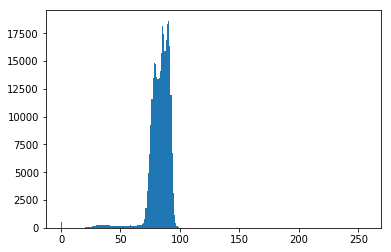

In [17]:
plt.hist(img.ravel(),256,[0,256]); plt.show()

# 1. Noise 해결 및 영상 개선
### 1-1 gray level 변환은 읽을 때 gray level로 읽어왔기 때문에 구현 x
### 1-2 노이즈와 이미지 대조비, 어두운 이미지 찾아 개선
일단 주어진 영상들에는 노이즈가 없는 영상들이라 적용할 필요가 없었지만 구현은 해놓겠다.

어두운 이미지 같은 경우도 이진화를 하면 전부 해결될 문제지만 한번 히스토그램을 분석해서 밝게 해보겠다.

대조비가 작은 것을 찾아 대조비를 살짝만 높게 바꿔주겠다.

82.48800455729166
수정전 이미지 평균 :  82.48800455729166
수정후 이미지 평균 :  161.59649088541667
수정전 이미지 분산 :  56.16783794653152
수정후 이미지 분산 :  173.50556575516592


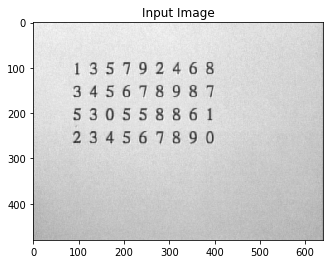

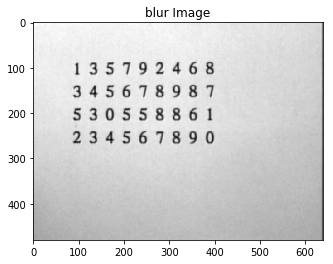

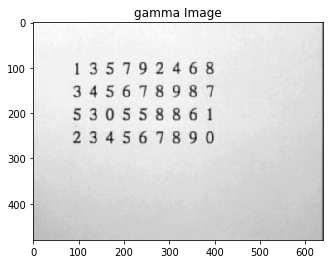

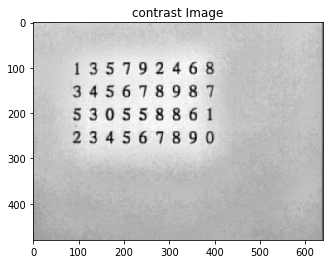

In [18]:
# input img
plt.figure(1)
plt.imshow(img, cmap = 'gray')
plt.title('Input Image')

# 기본적으로 gaussian filter 적용
blur_img = cv2.GaussianBlur(img, (5,5), 0)
plt.figure(2)
plt.imshow(blur_img, cmap = 'gray')
plt.title('blur Image')

cv2.namedWindow('blur image', cv2.WINDOW_NORMAL) 
cv2.imshow('blur image', blur_img)

# 히스토그램의 평균값이 126 보다 작으면 감마보정을 통해 밝게 해줌
if np.mean(blur_img) < 126:
    print('수정전 이미지 평균 : ', np.mean(blur_img))
    gamma_img = np.uint8((1 * np.power(blur_img/255, 0.4)) * 255)
    plt.figure(3)
    plt.imshow(gamma_img, cmap = 'gray')
    plt.title('gamma Image')
    print('수정후 이미지 평균 : ', np.mean(gamma_img))
else:
    gamma_img = blur_img
    

# 분산이 적을경우 숫자 인식이 쉽지 않아 밝은것은 밝게 어두운 것은 어둡게 설정
# 히스토 그램 균일화를 할경우 전체이미지에 적용이 되어 분산이 지나치게 커지게 된다.
# 그래서 작은 영역마다 균등화 해주는 clahe(Contrast Limited Adaptive Histogram Equalization)을 적용 시켰다.
if np.var(gamma_img) < 125:
    # contrast limit가 2이고 title의 size는 8X8
    clahe = cv2.createCLAHE(clipLimit= 2.0, tileGridSize=(8,8))
    contrast_img = clahe.apply(gamma_img)
    print('수정전 이미지 분산 : ', np.var(gamma_img))
    plt.figure(4)
    plt.imshow(contrast_img, cmap = 'gray')
    plt.title('contrast Image')
    print('수정후 이미지 분산 : ', np.var(contrast_img))
else:
    contrast_img = gamma_img

### 1-3. 적절할 임계값 찾아 이진화
### cv2.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)<br>
Parameters:	<br>
> src – grayscale image<br>
maxValue – 최대값<br>
adaptiveMethod – thresholding value를 결정하는 계산 방법<br>
thresholdType – threshold type<br>
blockSize – thresholding을 적용할 영역 사이즈<br>
C – 평균이나 가중평균에서 차감할 값<br>

기존에 모든 이미지에서 임계값을 찾았다면 작은 영역별로 임계값을 찾아 이진화 해주는 알고리즘이다. <br>
DAPTIVE_THRESH_GAUSSIAN_C : 가우시안분포로 이진화해줌

Text(0.5, 1.0, 'thresh Image')

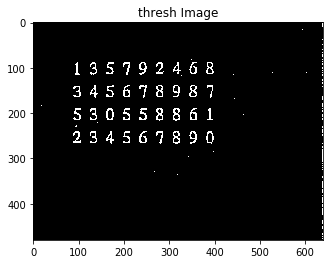

In [19]:
# 적절한 threshold값 찾아 이진화
# threshold 설명
thresh = cv2.adaptiveThreshold(contrast_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 1, 9, 4)
plt.figure(3)
plt.imshow(thresh, cmap = 'gray')
plt.title('thresh Image')

### 1-4 모폴로지 연산
이진화된 숫자 사진을 보면 5나 3 같은경우는 끊어진 경우가 보여 숫자를 찾을때 따로따로 영역을 검출하는 경우가 생긴다.<br>
그래서 모폴로지 연산중 closing : dilation -> erosion 팽창 후 침식을 통해 끊어진 부분을 이어주기로 했다.

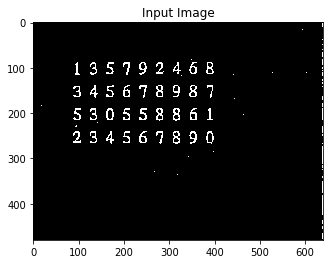

In [20]:
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.figure(4)
plt.imshow(closing, cmap = 'gray')
plt.title('Input Image')

## 2 숫자검출 및 학습데이터 저장

### 2 1 find contours를 활용한 숫자 검출
### Contours란 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선입니다. 우리가 자주 보는 것으로는 등고선이나 일기예보에서 볼 수 있습니다.
### cv2.findContours(image, mode, method[, contours[, hierarchy[, offset]]]) → image, contours, hierarchy
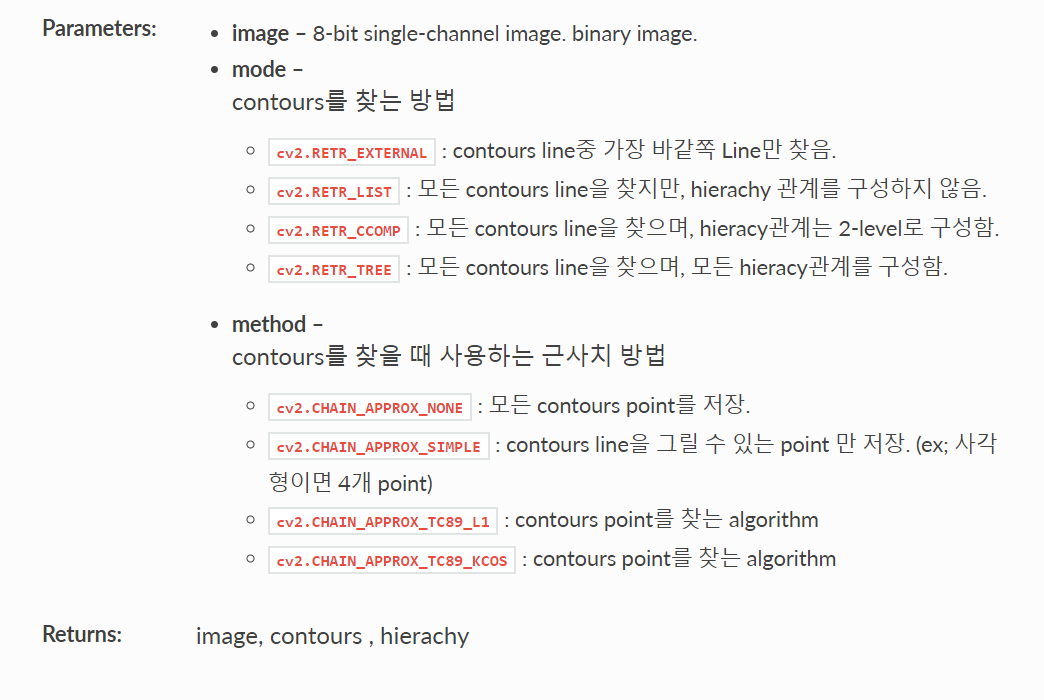

In [21]:
test, contours, hierarchy = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

### 2-2 학습데이터 구축

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


Text(0.5, 1.0, 'train complete')

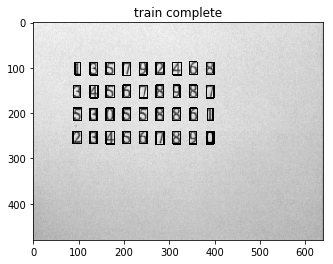

In [22]:
samples = np.empty((0,100))
answer = []
index = 1
# keys는 0 ~ 9 까지의 ascii코드를 담고있는 배열이다
keys = [i for i in range(48, 58)]

for cnt in contours:
    # 찾은 영역의 넓이가 50이상이면
    if cv2.contourArea(cnt) > 50 :
        #사각형을 표현하기 위한 4가지 점을 받는다
        [x, y, w, h] = cv2.boundingRect(cnt)

        if(h > 22 and h < 100):
            print(index)
            # 여기서 기존 이미지에 사각형 그려줌
            cv2.rectangle(img, (x, y), (x+w, y+h), (0,0, 255), 2)
            
            # 사각형 크기만큼의 이미지 배열 선언
            roi = thresh[y: y+h, x: x+h]
            
            # 사각형 크기를 균일하게 하기위해 재정의 해줌
            roismall = cv2.resize(roi, (10, 10))
            # 이미지 보여주기
            cv2.imshow('Enter answer key', img)
            
            cv2.waitKey()
            # 정답 입력하는 부분
            key = cv2.waitKey(0)
            
            # esc누르면 다음 contours 검색
            # 잘못된 contours가 들어올경우 esc 누르면 된다
            if key == 27:
                index += 1
                continue
                
            # 만약에 입력한 키가 0 ~ 9 사이라면 sample 어레이와 answer 어레이에 추가해준다.
            elif key in keys:
                # 입력한 키를 answer 배열에 어펜드
                answer.append(int(chr(key)))
                # sample 매트릭스를 1차원 배열로 변환해서 저장
                sample = roismall.reshape((1, 100))
                # 숫자가 어떤 형식으로 저장되는지 확인하는 구문
                if(index == 8):
                    np.savetxt('number_print_text', np.column_stack(roi), '%d\t')
                # samples 에 숫자 이미지 배열 추가
                samples = np.append(samples, sample, 0)
            
            # roismall 크기 recover     
            roismall = cv2.resize(roi,(10, 10))
            index += 1
    
cv2.destroyAllWindows()
plt.figure(1)
plt.imshow(img, cmap = 'gray')
plt.title('train complete')

# 2-3. 학습데이터 저장
train data를 많이 만들기위해<br>
기존 파일에 append하는 형식으로 만들어줌

In [8]:
with open('samples.data', 'ab') as f_handle:
    np.savetxt(f_handle, samples)
with open('answer.data', 'ab') as f_handle:
    np.savetxt(f_handle, answer)